<a href="https://colab.research.google.com/github/littlejacinthe/Machine-Learning-Programming/blob/master/Copy_of_lesson7_superres_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pretrained GAN

In [ ]:
!pip install fastai

In [ ]:
!pip install torch==1.4.0

     |████████████████████████████████| 753.4MB 23kB/s 
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.4.0 which is incompatible.


In [ ]:
!pip install torchvision==0.5.0

     |████████████████████████████████| 4.0MB 8.7MB/s 


In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images' #path for original images
path_lr = path/'crappy' #path for preprocessed images

## Crappified data

Prepare the input data by crappifying images.

In [ ]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [ ]:
from crappify import * #--> replaced by the function above

ModuleNotFoundError: ignored

Uncomment the first time you run this notebook.

In [ ]:
il = ImageList.from_folder(path_hr) #loading the files
parallel(crappifier(path_lr, path_hr), il.items) #crappifying them

For gradual resizing we can change the commented line here.

In [ ]:
bs,size=32, 128 #choosing batch size and size of images
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34 #this will be our model

## Pre-train generator

Now let's pretrain the generator.

In [ ]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42) #splitting the preprocessed data, 10% validation

In [ ]:
res = [rand_crop()]
trans = res.append(rand_zoom(scale=(1.,2.), p=0.75))

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name) #label function from the name of the files
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True) #zoom in the images, same transform for every file
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True)) #making batches and then normalizing them

    data.c = 3
    return data

In [ ]:
data_gen = get_data(bs,size) #load all

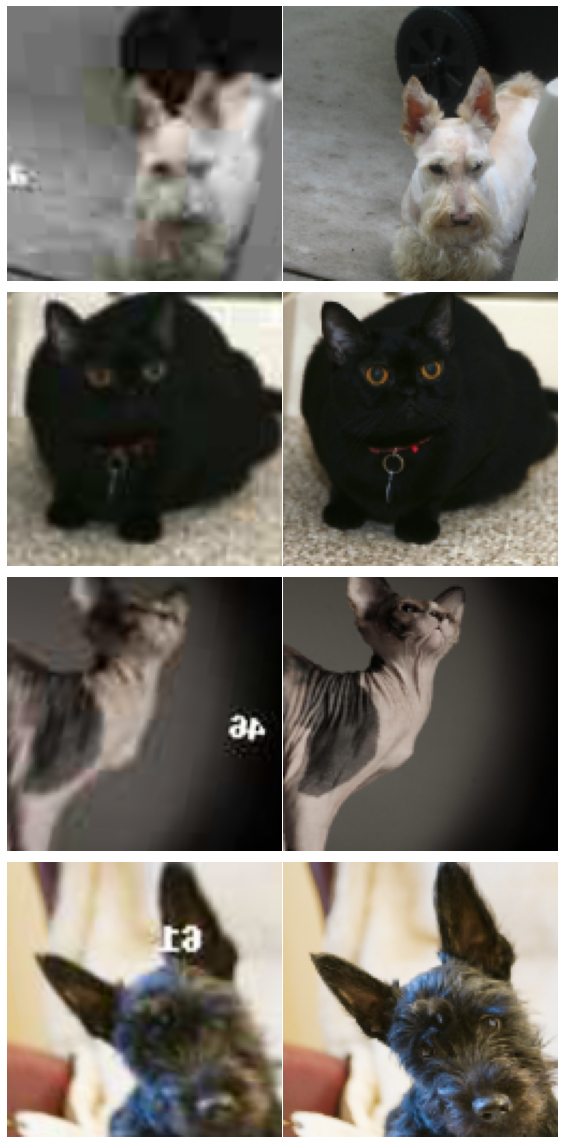

In [ ]:
data_gen.show_batch(4)

In [ ]:
wd = 1e-3 #learning rate

In [ ]:
y_range = (-3.,3.) #range

In [ ]:
loss_gen = MSELossFlat() #loss function

In [ ]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, #learner on our data
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner() #loading resnet 34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8) #train

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3)) #learning on a different slice

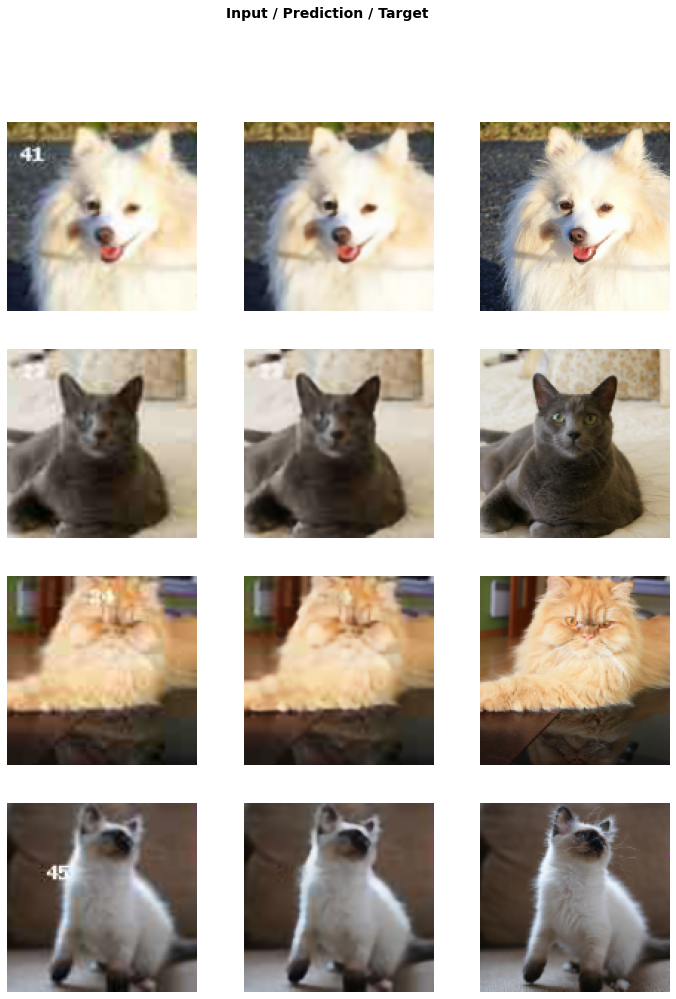

In [ ]:
learn_gen.show_results(rows=4) #pictures look good

In [ ]:
learn_gen.save('gen-pre2') #saving results

## Save generated images

In [ ]:
learn_gen.load('gen-pre2');

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True) #making the path for our generated images

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True) #save predictions from each batch
        for o in preds:
            o.save(path_gen/names[i].name) #file names
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

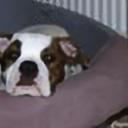

In [ ]:
PIL.Image.open(path_gen.ls()[0]) #check an image to make sure everything went smoothly

## Train critic

In [ ]:
learn_gen=None
gc.collect() #collect the generated images

22

Pretrain the critic on crappy vs not crappy.

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42) #dataset in classes, 10% validation
    ll = src.label_from_folder(classes=classes) #labels
    data = (ll.transform(get_transforms(max_zoom=2.), size=size) #transform as before
           .databunch(bs=bs).normalize(imagenet_stats)) #normalize, bunches
    data.c = 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size) #our crit data is the original images

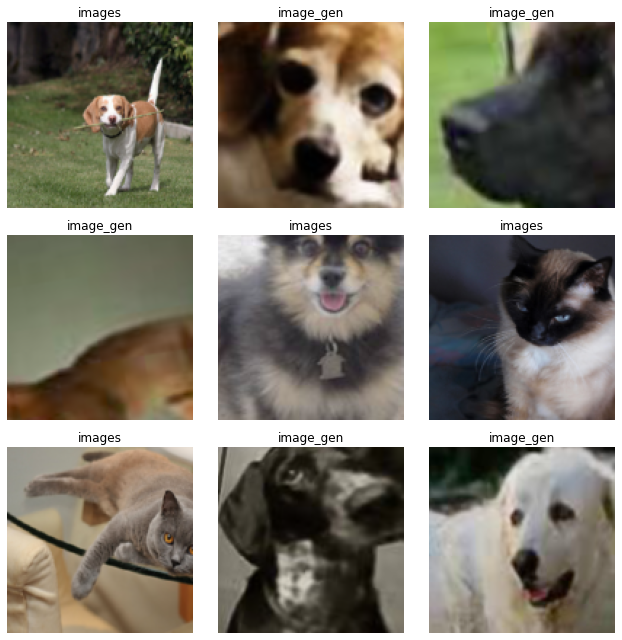

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3) #let's see a batch

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss()) #loss function

In [ ]:
def create_critic_learner(data, metrics): #learner for the critic
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3) #train : validation loss goes back up on 3rd epoch. ATE up. Good results from 4th epoch

In [ ]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

19418

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size) #now we get both crappy and normal data

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2') #load the critic

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2') #load the generator

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65) #when to switch between G and D. Switches when loss goes below threshold
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher, #GAN learner
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4 #learning rate

In [ ]:
learn.fit(40,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192) #smaller batches but bigger images

In [ ]:
learn.fit(10,lr/2) #training 

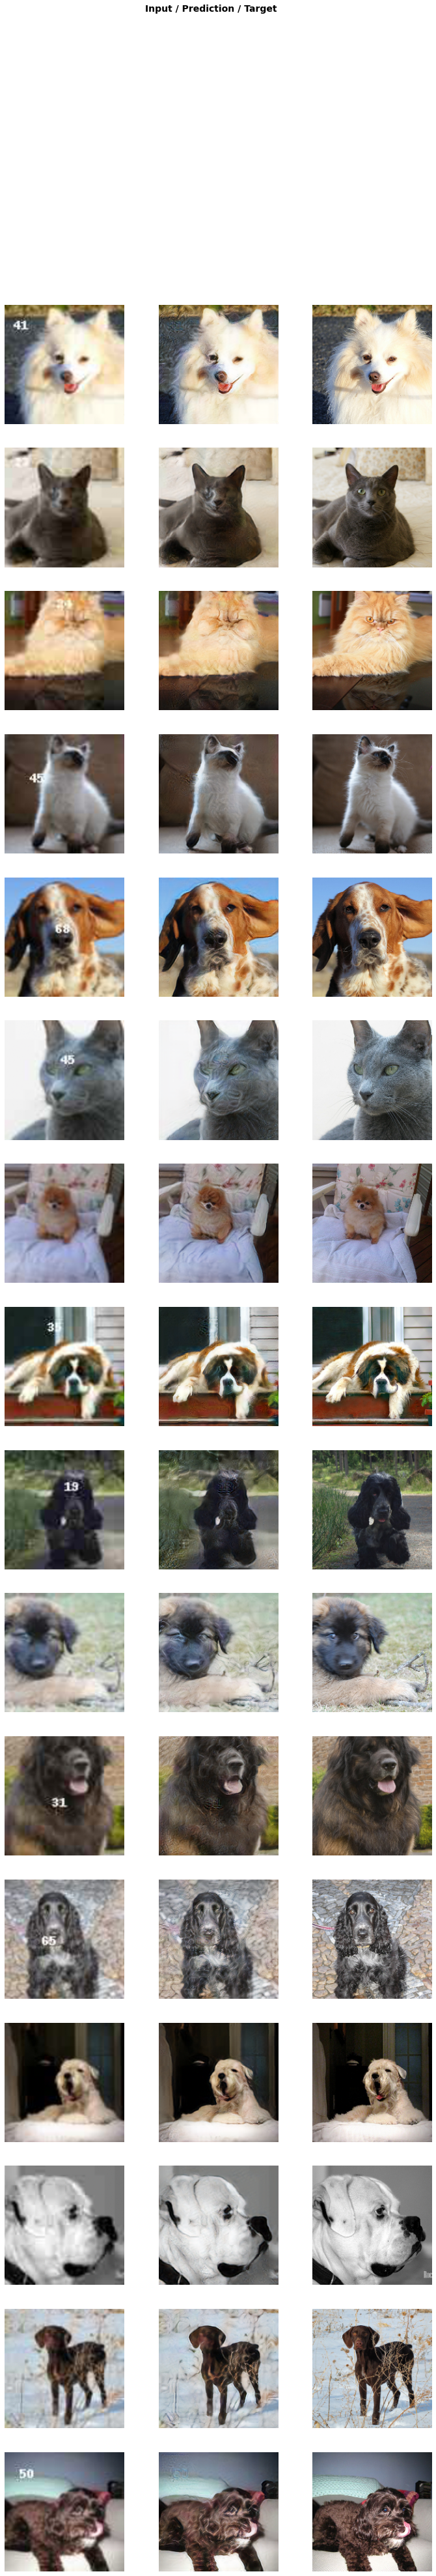

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

## fin